In [1]:
#目标
# 1.颜色之间的距离
# 2.色块大小、数量的直方图和曲线
# 3.x、y方向上的投影分布曲线

In [2]:
import cv2 as cv 
import matplotlib.pyplot as plt
import pandas  as pd
import numpy as np
import math
from sklearn.cluster import KMeans
from skimage import io
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from scipy.spatial import KDTree
from skimage.color import lab2rgb, lch2lab
from sklearn import metrics
import csv

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# csvname = 'shandong/山东白麻2307202B73标板.csv'
#csvname = 'shandong/山东白麻2308282D06版面效果OK.csv'
#csvname = 'shandong/山东白麻2309062c60颜色深黑色碎点多.csv'
csvname = 'shandong/山东白麻2309272A10色点密度偏多，整体颜色黄.csv'
#csvname = 'shandong/山东白麻2312192A60颜色整体偏黄.csv'
# csvname = '2BIAOZHUN.csv'
labcount = 0
labpixel = 0
allLAB = []
allLABch = []
allLch = []
with open(csvname, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    header = next(csv_reader)
    labcount = int(header[0])
    labpixel = int(header[1])
    rows = list(csv_reader)
    # print(len(rows))
    for row in rows:
        row_split = [float(x) for x in row]
        allLAB.append([row_split[0],row_split[1],row_split[2]])
        allLABch.append([row_split[0],row_split[1],row_split[2],row_split[3],row_split[4]])
        allLch.append([row_split[0],row_split[3],row_split[4]])

In [4]:
print(len(allLAB))
print(labcount)
print(labpixel)

1472896
4736
311


In [5]:
newCount = int(labcount/4)
newPixel = int(labpixel*4)
allLAB_array = np.zeros((newCount, newPixel, 3), dtype=np.float32)
allLABch_array = np.zeros((newCount, newPixel, 5), dtype=np.float32)
allLch_array = np.zeros((newCount, newPixel, 3), dtype=np.float32)
print(allLAB_array.shape)
type(allLAB_array)

(1184, 1244, 3)


numpy.ndarray

In [6]:
for i in range(newCount):
    for j in range(newPixel):
        tempij = (i + int(j/labpixel)*newCount)*labpixel + (j % labpixel)
        allLAB_array[i][j] = allLAB[tempij]
        allLABch_array[i][j] = allLABch[tempij]
        allLch_array[i][j] = allLch[tempij]

In [7]:
LAB_array = np.transpose(allLAB_array, (1, 0, 2))
LABch_array = np.transpose(allLABch_array, (1, 0, 2))
Lch_array = np.transpose(allLch_array, (1, 0, 2))

In [8]:
LAB_array.shape

(1244, 1184, 3)

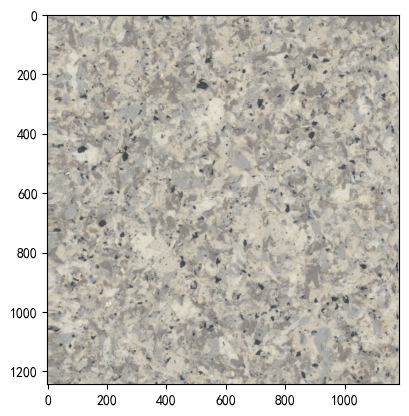

In [9]:
rgb_matrix = lab2rgb(LAB_array)
plt.imshow(rgb_matrix)

cluster_colors:
[70.743065  -0.6285727  5.688874 ]
[79.70482    -0.76917315  7.246855  ]
[40.04142   -0.6817056  0.4914384]
[60.708405   0.1499902  4.788024 ]


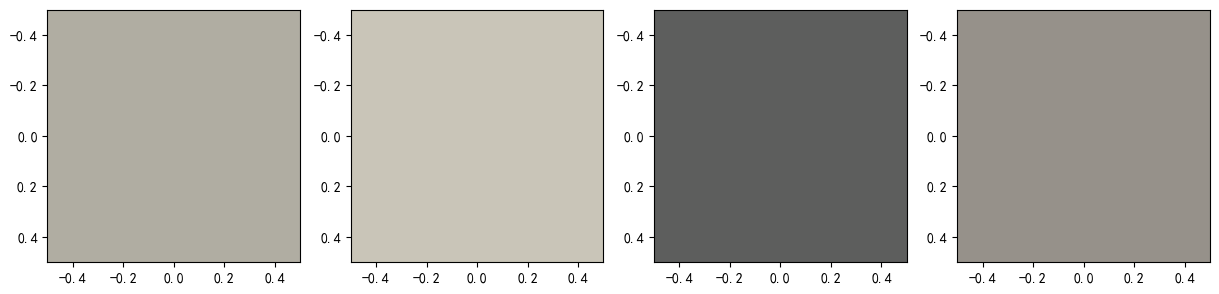

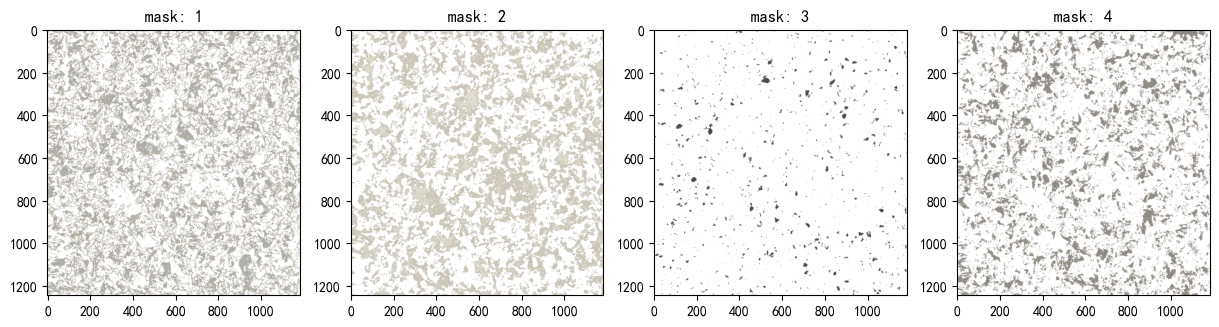

cluster_Labch:
[70.76166, -0.629185, 5.6917825, 5.759619, 97.67104]
[79.71431, -0.76934606, 7.2477474, 7.2994275, 96.46996]
[40.061604, -0.6811648, 0.49489936, 1.7245653, 173.56784]
[60.7262, 0.14852661, 4.790491, 4.8710256, 90.140434]


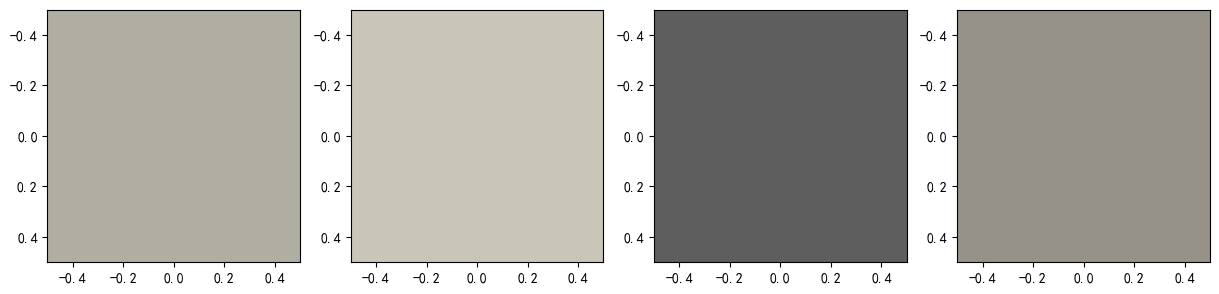

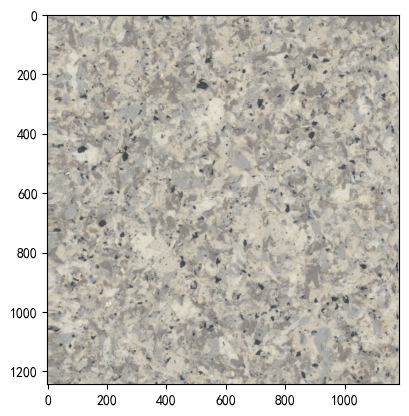

In [10]:
temp_array = np.array(LAB_array)
image_array = rgb_matrix#np.array(rgb_matrix)
# 将图像数组展平成一维数组
flattened_array = temp_array.reshape(-1, 3)
num_clusters = 4
# KMeans
kmeans = KMeans(n_clusters=num_clusters)
y_pred = kmeans.fit(flattened_array)
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_
# 每个聚类中像素的掩码
cluster_masks = []
for i in range(num_clusters):
    cluster_masks.append((cluster_labels == i).reshape(image_array.shape[0], image_array.shape[1]))

# 聚类中心颜色
cluster_colors = []
for center in cluster_centers:
    cluster_colors.append(center)
print("cluster_colors:")
for center in cluster_centers:
    print(f"{center}")
fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))
for i in range(num_clusters):
    # temp_lab = np.array([[(int(cluster_colors[i][0]),int(cluster_colors[i][1]),int(cluster_colors[i][2]))]])
    temp_lab = np.array([[(cluster_colors[i][0],cluster_colors[i][1],cluster_colors[i][2])]])
    temp_rgb = lab2rgb(temp_lab)
    axs[i].imshow(temp_rgb)
    # axs[i].set_title(f"colors: {cluster_colors[i]}")
plt.show()

# 每个聚类中像素的图像
cluster_images = []
for i in range(num_clusters):
    cluster_images.append(image_array.copy())
    cluster_images[i][~cluster_masks[i]] = 1
fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))
for i in range(num_clusters):
    axs[i].imshow(cluster_images[i])
    axs[i].set_title(f"mask: {i+1}")
plt.show()
allcolor = []
print("cluster_Labch:")
all_Labch_mean = []
fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))
for i in range(num_clusters):
    Labch_mean = [LABch_array[cluster_masks[i]][:,0].mean(),
                  LABch_array[cluster_masks[i]][:,1].mean(),
                  LABch_array[cluster_masks[i]][:,2].mean(),
                  LABch_array[cluster_masks[i]][:,3].mean(),
                  LABch_array[cluster_masks[i]][:,4].mean()]
    print(Labch_mean)
    all_Labch_mean.append(Labch_mean)
    temp_lab = np.array([[(LABch_array[cluster_masks[i]][:,0].mean(),LABch_array[cluster_masks[i]][:,1].mean(),LABch_array[cluster_masks[i]][:,2].mean())]])
    temp_rgb = lab2rgb(temp_lab)
    allcolor.append(temp_rgb)
    axs[i].imshow(temp_rgb)
plt.show()

plt.imshow(rgb_matrix)

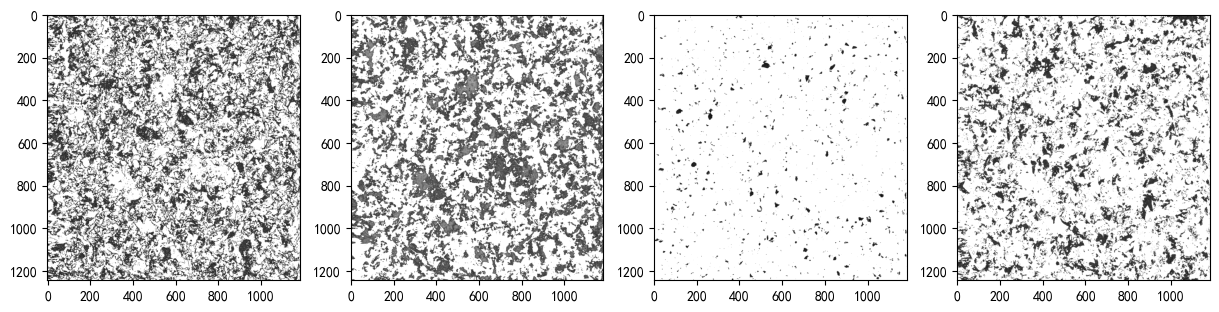

In [11]:
from sklearn.cluster import DBSCAN
new_rgb_matrix = []
img_temp = []
for i in range(num_clusters):
    new_rgb_matrix.append(cluster_images[i])
    img_temp.append(cv.cvtColor(new_rgb_matrix[i],cv.COLOR_BGR2GRAY))
fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))
for i in range(num_clusters):
    axs[i].imshow(img_temp[i],cmap=plt.get_cmap('gray'))
plt.show()
# plt.imshow(img_temp2,cmap=plt.get_cmap('gray'))

In [12]:
allret = []
allrecon = []
allpoints = []
allresult = []
for i in range(num_clusters):
    the,ret = cv.threshold(img_temp[i],0.99,1,cv.THRESH_BINARY)
    allret.append(ret)
    # plt.imshow(ret,cmap=plt.get_cmap('gray'))
    the,ret_temp2 = cv.threshold(img_temp[i],0.99,1,cv.THRESH_BINARY_INV) 
    # plt.imshow(ret_temp2,cmap=plt.get_cmap('gray'))
    recon = np.zeros_like(ret_temp2)
    x = np.argwhere(ret_temp2)
    c = DBSCAN(eps=2, min_samples=5).fit(x)
    # c.labels_
    labels = c.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    # n_clusters_
    X = x
    db = c
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    points = []
    for k, col in zip(unique_labels, colors):
        if k == -1:
            continue
            # Black used for noise.
            col = [0, 0, 0, 1]
        class_member_mask = labels == k
        xy = X[class_member_mask & core_samples_mask]
        if len(xy) > 4:
            points.append(xy)
    allpoints.append(points)
    print(len(points))
    result = {}
    i_r = 0
    for c1 in points:
        if len(c1)<5:
            continue
        recon[c1[:,0],c1[:,1]] = 255
        result[i_r] = {"族群大小":len(c1),"坐标":(c1[:,0].mean().round(2),c1[:,1].mean().round(2))}
        i_r += 1
    allrecon.append(recon)
    allresult.append(result)


1158
1169
731
2077


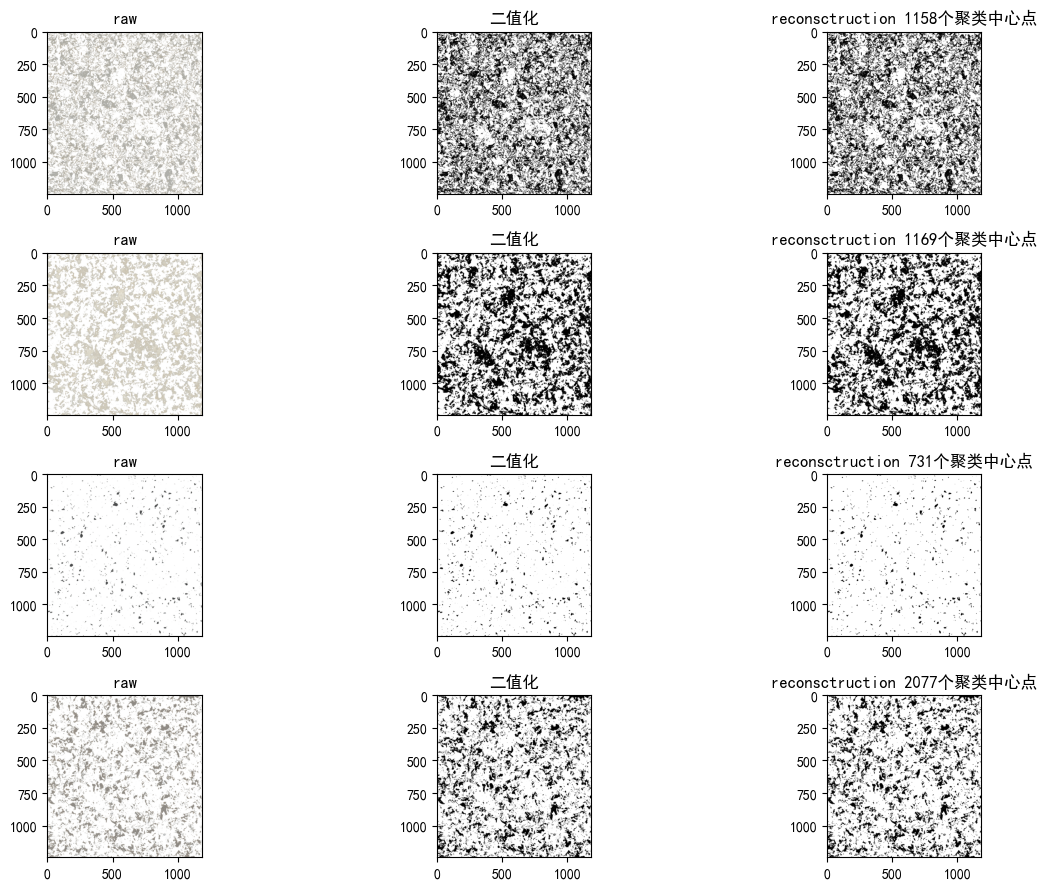

In [13]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(13,9))
# plt.xticks([])
# fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))
for i in range(num_clusters):
    ax1 = plt.subplot(num_clusters, 3, i*3 + 1)
    ax2 = plt.subplot(num_clusters, 3, i*3 + 2)
    ax3 = plt.subplot(num_clusters, 3, i*3 + 3)
    ax2.imshow(allret[i],cmap=plt.get_cmap('gray'))
    rec = ~(allrecon[i] > 1)
    ax3.imshow(rec,cmap=plt.get_cmap('gray'))
    ax1.title.set_text("raw")
    ax2.title.set_text("二值化")
    ax3.title.set_text(f"reconsctruction {len(allpoints[i])}个聚类中心点")
    ax1.imshow(new_rgb_matrix[i])#.astype('uint8')
plt.tight_layout()
plt.show()

points Mean: 455.9715025906736  points Variance: 55056091.2349392 
points Mean: 463.49871685201026  points Variance: 9449623.839390997 
points Mean: 49.87824897400821  points Variance: 5515.105559724605 
points Mean: 148.80211844005777  points Variance: 275913.9902121709 


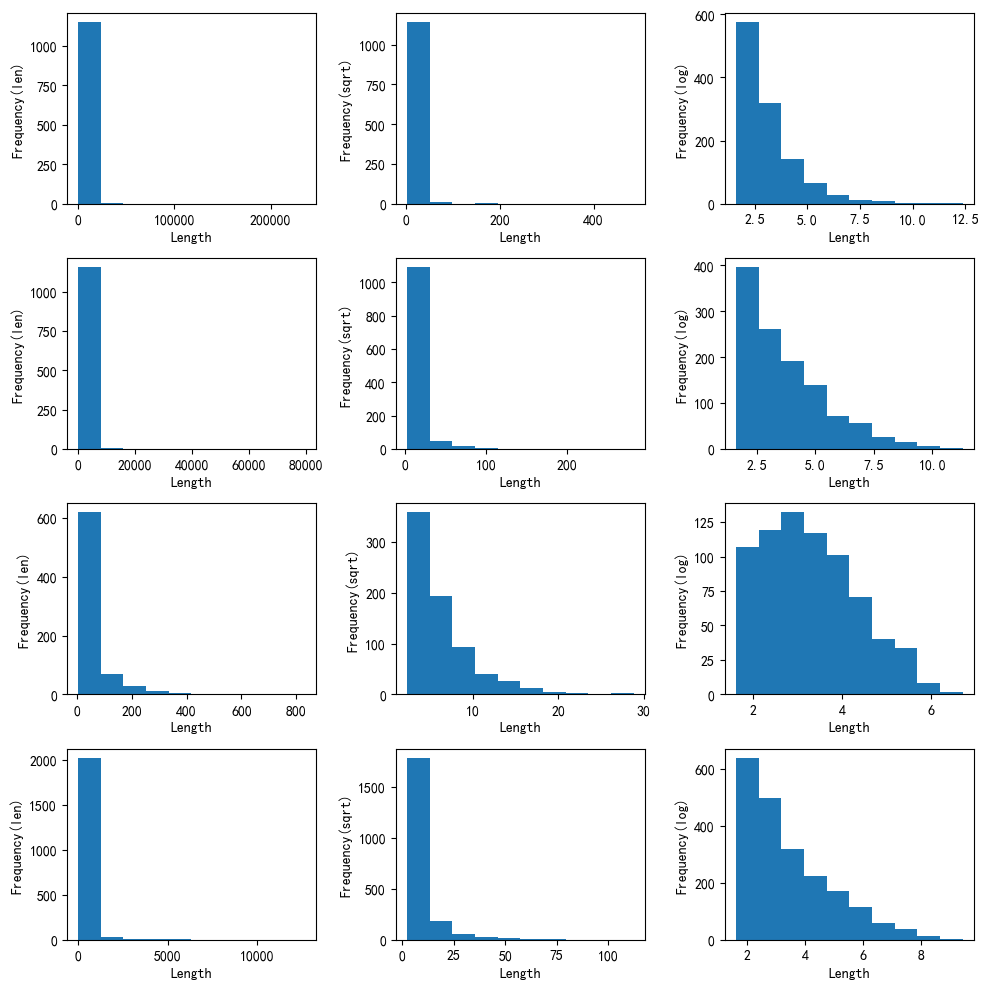

In [14]:
plt.figure(figsize=(10,10))
for i in range(num_clusters):
    points_lens = [len(x) for x in allpoints[i]]
    points_lens_log = [math.log(x) for x in points_lens]
    points_lens_sqrt = [math.sqrt(x) for x in points_lens]
    ax1 = plt.subplot(num_clusters, 3, i*3 + 1)
    ax2 = plt.subplot(num_clusters, 3, i*3 + 2)
    ax3 = plt.subplot(num_clusters, 3, i*3 + 3)
    ax1.hist(points_lens)
    ax1.set_xlabel('Length')
    ax1.set_ylabel('Frequency(len)')
    ax2.hist(points_lens_sqrt)
    ax2.set_xlabel('Length')
    ax2.set_ylabel('Frequency(sqrt)')
    ax3.hist(points_lens_log)
    ax3.set_xlabel('Length')
    ax3.set_ylabel('Frequency(log)')
    points_mean = np.mean(points_lens)
    points_variance = np.var(points_lens)
    print(f"points Mean: {points_mean}  points Variance: {points_variance} ")
plt.tight_layout()
plt.show()

色块总比例占比：35.85%    	色块大小 均值: 455.972, 	方差: 55056091.235
色块总比例占比：36.79%    	色块大小 均值: 463.499, 	方差: 9449623.839
色块总比例占比：2.48%    	色块大小 均值: 49.878, 	方差: 5515.106
色块总比例占比：20.98%    	色块大小 均值: 148.802, 	方差: 275913.99


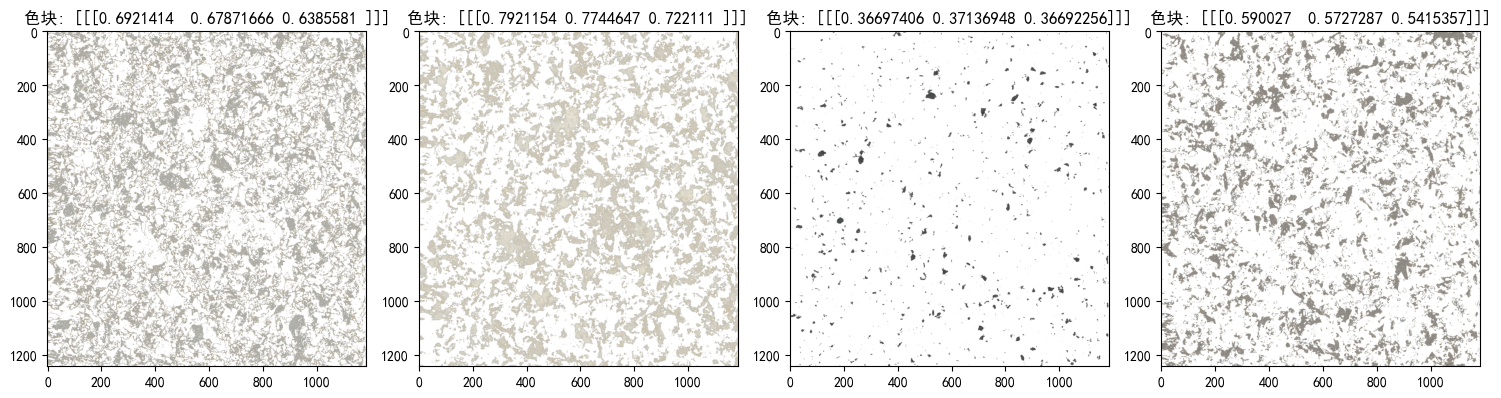

In [15]:
fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))
for i in range(num_clusters):
    points_lens = [len(x) for x in allpoints[i]]
    area = sum(points_lens)
    area_rate = area / (rgb_matrix.shape[0] * rgb_matrix.shape[1])
    points_mean = np.mean(points_lens)
    points_variance = np.var(points_lens)
    print(f"色块总比例占比：{round(area_rate*100, 2)}%    \t色块大小 均值: {round(points_mean,3)}, \t方差: {round(points_variance,3)}")
    axs[i].imshow(cluster_images[i])
    axs[i].set_title(f"色块: {allcolor[i]}")
plt.tight_layout()
plt.show()

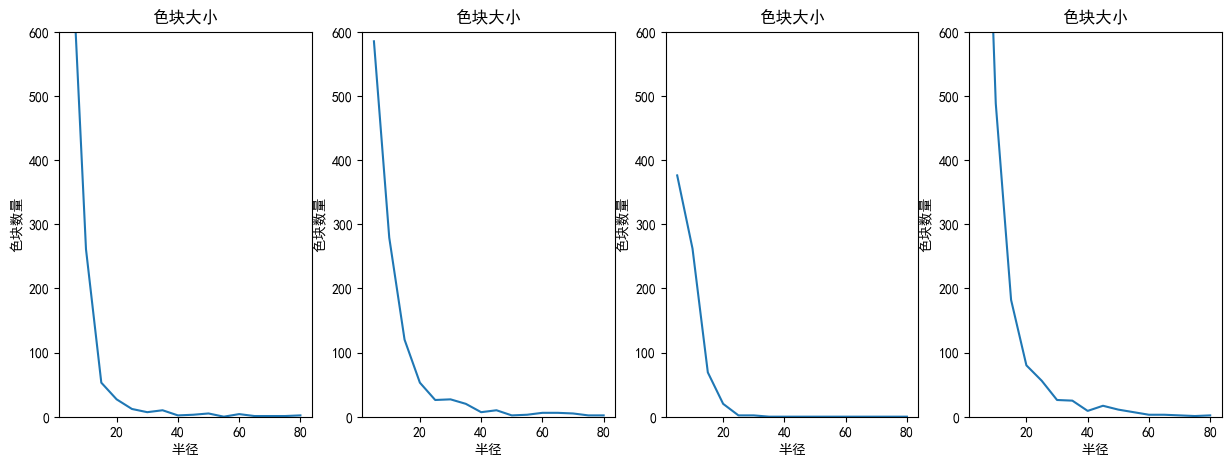

In [16]:
fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5))
for i in range(num_clusters):
    points_lens = [len(x) for x in allpoints[i]]
    area_step = 5
    step_num = round(80 / area_step)
    area_list = []
    for j in range(step_num):
        area_list.append((j + 1) * area_step)
    # print(area_list)
    sum_points_list = np.zeros_like(area_list)
    
    for k in range(step_num):
        low = 0
        if k > 0:
            low = area_list[k-1] * area_list[k-1]
        high = area_list[k]*area_list[k]
        sum_points_list[k] = sum(low < num <= high for num in points_lens)
    
    axs[i].plot(area_list, sum_points_list)
    axs[i].set_title(f"色块大小")
    axs[i].set_ylim(0, 600)
    axs[i].set_xlabel("半径")
    axs[i].set_ylabel("色块数量")
plt.show()

In [17]:
def get_k_nearest(points_list):
    k = 10
    # 创建 KD 树以快速查找最近邻居
    tree = KDTree(points_list)
    # 初始化 k 近邻距离列表
    k_nearest_neighbor_distances = []
    # 对于每个坐标，找到其最近的 k 个邻居
    for temp_inside in points_list:
        # 查询 KD 树以查找最近的 k 个邻居
        distances, indices = tree.query(temp_inside, k=k+1)
        # 计算 k 近邻距离（不包括查询点本身）
        k_nearest_neighbor_distance = np.mean(distances[1:])
        # 将 k 近邻距离添加到列表中
        k_nearest_neighbor_distances.append(k_nearest_neighbor_distance)
    return k_nearest_neighbor_distances

In [18]:
all_k_nearest_neighbor_distances = []
for i in range(num_clusters):
    insides = []
    for c1 in allpoints[i]:
        insides.append((c1[:,0].mean(), c1[:,1].mean()))
    insides = np.array(insides)
    k_nearest_neighbor_distances = get_k_nearest(insides)
    all_k_nearest_neighbor_distances.append(k_nearest_neighbor_distances)
    knnd_mean = np.mean(k_nearest_neighbor_distances)
    knnd_variance = np.var(k_nearest_neighbor_distances)
    print(f"色块k近邻距离 均值: {round(knnd_mean,3)}, \t方差: {round(knnd_variance,3)}")

色块k近邻距离 均值: 43.592, 	方差: 127.522
色块k近邻距离 均值: 43.715, 	方差: 106.525
色块k近邻距离 均值: 57.697, 	方差: 173.175
色块k近邻距离 均值: 33.407, 	方差: 54.365


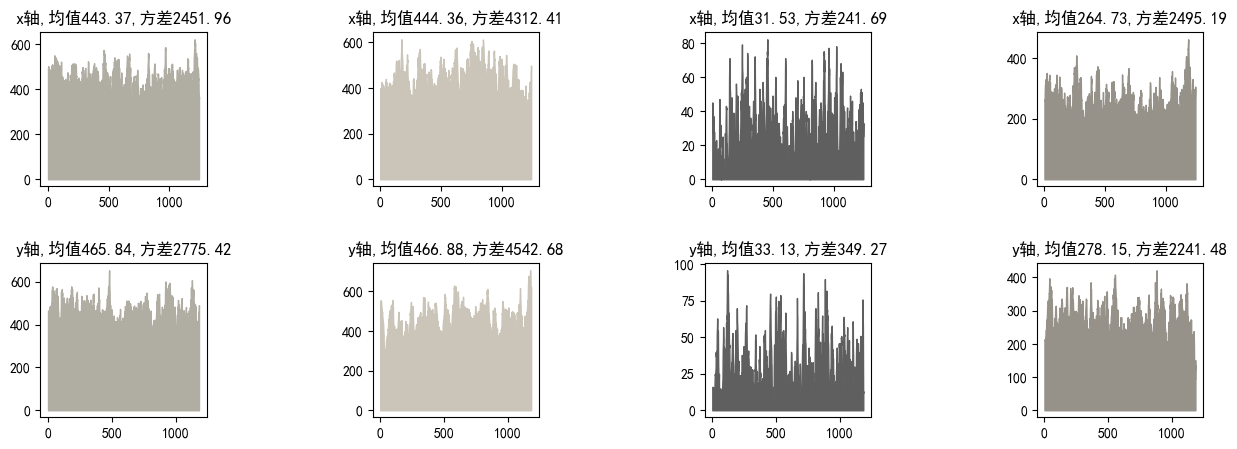

In [19]:
fig, axs = plt.subplots(2, num_clusters, figsize=(15,5))
for i in range(num_clusters):
    x0_1 = range(allret[i].shape[0])
    y0_1 = np.sum(allret[i] == 0, axis=1)
    y0_1_mean = round(np.mean(y0_1),2)
    y0_1_var = round(np.var(y0_1),2)
    x1_1 = range(allret[i].shape[1])
    y1_1 = np.sum(allret[i] == 0, axis=0)
    y1_1_mean = round(np.mean(y1_1),2)
    y1_1_var = round(np.var(y1_1),2)
    axs[0][i].fill_between(x0_1,y0_1, 0, color=allcolor[i])
    axs[1][i].fill_between(x1_1,y1_1, 0, color=allcolor[i])
    # axs[0][i].set_ylim(0,500)
    # axs[1][i].set_ylim(0,500)
    axs[0][i].set_title(f"x轴,均值{y0_1_mean},方差{y0_1_var}")
    axs[1][i].set_title(f"y轴,均值{y1_1_mean},方差{y1_1_var}")
plt.subplots_adjust(hspace=0.5, wspace=1)
plt.show()

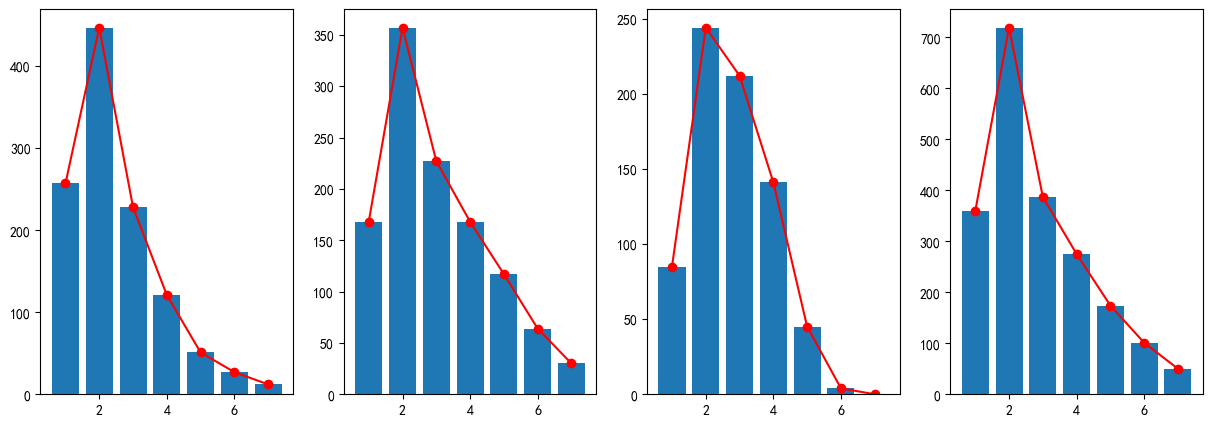

In [20]:
fig, axs = plt.subplots(1, num_clusters, figsize=(15,5))
for i in range(num_clusters):
    points_lens = [len(x) for x in allpoints[i]]
    points_lens_log = [math.log(x) for x in points_lens]
    logdist = {}
    # max_value = int(max(points_lens_log)) + 1
    max_value = 8
    for key in range(1, max_value):
        newlist = [x for x in points_lens_log if key <= x < key+1]
        # if len(newlist) > 0:
        logdist[key] = len(newlist)
    keys = list(logdist.keys())
    values = list(logdist.values())
    axs[i].bar(keys,values)
    axs[i].plot(keys, values, 'ro-')
plt.show()

In [21]:
def get_kmeans_score(clusters_num):
    kmeans2 = KMeans(n_clusters=clusters_num)
    y_pred = kmeans2.fit_predict(flattened_array)
    score= metrics.calinski_harabasz_score(flattened_array, y_pred)
    # fig, axs = plt.subplots(1, clusters_num, figsize=(6, 2))
    # i = 0
    # for center in kmeans2.cluster_centers_:
    #     temp_lab = np.array([[(center[0],center[1],center[2])]])
    #     temp_rgb = lab2rgb(temp_lab)
    #     axs[i].imshow(temp_rgb)
    #     axs[i].set_title(f"color: {[round(temp_rgb[0][0][0],2),round(temp_rgb[0][0][1],2),round(temp_rgb[0][0][2],2)]}")
    #     i+=1
    #     # axs[i].set_title(f"colors: {cluster_colors[i]}")
    # plt.tight_layout()
    # plt.show()
    return score

In [22]:
for batch in range(2, 7):
    score = get_kmeans_score(batch)
    print(f"num_clusters = {batch}, score = {score}")

num_clusters = 2, score = 2187864.341421411
num_clusters = 3, score = 2322706.7263406324
num_clusters = 4, score = 3089559.040322718
num_clusters = 5, score = 3219282.9426134597
num_clusters = 6, score = 3247374.175908992
